In [2]:
import pandas as pd
import numpy as np
import pickle
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Some handy functions

In [3]:
# Functions for processing input

def convert_Actigraph_datetime(row):
    """Convert string in column 'time' in H:M:S format to datetime"""
    return pd.to_datetime(row['time'], format='%H:%M:%S').time()

def convert_Activity_Start_datetime(row):
    """Convert string in column 'Start' in H:M format to datetime"""
    return pd.to_datetime(row['Start'], format='%H:%M').time()

def convert_Activity_End_datetime(row):
    """Convert string in column 'End' in H:M format to datetime"""
    if row['End'] == '24:00':
        return pd.to_datetime('0:00', format='%H:%M').time()
    elif pd.isnull(row['End']):
        return row['Start']
    else:
        return pd.to_datetime(row['End'], format='%H:%M').time()

def label_actigraph(row, df):
    """For each row in Actigraph_df, check if that time is part of activity log. If so, return activity code(s)"""
    day = row['day']
    time = row['time']
    label = []  
    for i in range(len(df)):
        if day == df.Day.loc[i] and ((time >= df.Start.loc[i]) and (time <= df.End.loc[i])):
            label.append(df.Activity.loc[i])
    if label:
        return label
    else:
        label.append(0)
        return label

def RMSSD(RR_list):
    return np.sqrt(np.sum((np.diff((np.array(RR_list)*1000))**2)/(len(RR_list)-1)))

def correct_day(row):
    if (row['day'] != 1) and (row['day'] != 2):
        return 2
    else:
        return row['day']

# Read in data, add activity labels, concatenate

In [ ]:
# Produce an annotated df with actigraphy data labelled with activities for all users

# ~30 mins to run
root = 'data/DataPaper/user_'
df = pd.DataFrame()

for i in range(1,23):
    
    # Define paths
    Actigraph_path = root + str(i) + '/Actigraph.csv'
    Activity_path = root + str(i) + '/Activity.csv'
    
    # Read in the data
    Actigraph_df = pd.read_csv(Actigraph_path)
    Activity_df = pd.read_csv(Activity_path)

    # Create a 'user' column in the Actigraph_df
    Actigraph_df['User'] = i
    
    # Convert time strings in dfs to datetime objects
    Actigraph_df['time'] = Actigraph_df.apply(convert_Actigraph_datetime, axis=1)
    Activity_df['Start'] = Activity_df.apply(convert_Activity_Start_datetime, axis=1)
    Activity_df['End'] = Activity_df.apply(convert_Activity_End_datetime, axis=1)
    
    # Add activity labels to Actigraph_df
    Actigraph_df['Activity'] = Actigraph_df.apply(label_actigraph, df=Activity_df, axis=1)
    
    # Append Actigraph_df to main df
    df = df.append(Actigraph_df)

In [ ]:
# Some of the "day 2" have values other than "2"...correct that.
df['day'] = df.apply(correct_day, axis=1)

In [ ]:
# pickle the annotated/ pooled actigraphy data
with open('Actigraphy_labelled.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

# Remove outliers

In [5]:
# read in the labelled activities
with open('Actigraphy_labelled.pickle','rb') as read_file:
    Actigraphy_labelled = pickle.load(read_file)
    
Actigraphy_labelled

,Unnamed: 0,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,User,Activity
0,82,0,0,0,0,68.0,0,1,0,0,0.00,1,10:10:22,1,[2]
1,83,11,4,7,1,68.0,0,1,0,0,13.64,1,10:10:23,1,[2]
2,84,0,21,10,0,68.0,0,0,1,0,23.26,1,10:10:24,1,[2]
3,85,0,1,24,0,68.0,0,0,1,0,24.02,1,10:10:25,1,[2]
4,86,34,14,63,1,154.0,0,1,0,0,72.95,1,10:10:26,1,[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67869,84411,90,115,80,0,72.0,0,1,0,0,166.51,2,08:38:51,22,[0]
67870,84412,33,49,28,1,72.0,0,1,0,0,65.38,2,08:38:52,22,[0]
67871,84413,32,25,34,0,72.0,0,1,0,0,52.96,2,08:38:53,22,[0]
67872,84414,59,28,188,1,72.0,0,1,0,0,199.02,2,08:38:54,22,[0]


In [6]:
#reset the index
Actigraphy_labelled = Actigraphy_labelled.reset_index()

# Remove unnecessary columnns
Actigraphy_labelled = Actigraphy_labelled.drop(columns=['index','Unnamed: 0'])
Actigraphy_labelled

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,User,Activity
0,0,0,0,0,68.0,0,1,0,0,0.00,1,10:10:22,1,[2]
1,11,4,7,1,68.0,0,1,0,0,13.64,1,10:10:23,1,[2]
2,0,21,10,0,68.0,0,0,1,0,23.26,1,10:10:24,1,[2]
3,0,1,24,0,68.0,0,0,1,0,24.02,1,10:10:25,1,[2]
4,34,14,63,1,154.0,0,1,0,0,72.95,1,10:10:26,1,[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462673,90,115,80,0,72.0,0,1,0,0,166.51,2,08:38:51,22,[0]
1462674,33,49,28,1,72.0,0,1,0,0,65.38,2,08:38:52,22,[0]
1462675,32,25,34,0,72.0,0,1,0,0,52.96,2,08:38:53,22,[0]
1462676,59,28,188,1,72.0,0,1,0,0,199.02,2,08:38:54,22,[0]


### Remove rows with HR > or < 2 SD from mean

In [9]:
# Define parameters for each user heart rate
user = []
hr_upper = []
hr_lower = []
for i in range(1,23):
    user.append(i)
    mean = Actigraphy_labelled[Actigraphy_labelled['User']==i].describe().HR.loc['mean']
    std = Actigraphy_labelled[Actigraphy_labelled['User']==i].describe().HR.loc['std']
    hr_upper.append(mean + (2*std))
    hr_lower.append(mean - (2*std))

idx_outliers = []
for usr, upp, low in zip(user, hr_upper, hr_lower):
    id_list = Actigraphy_labelled[(Actigraphy_labelled['User']==usr) & \
                                  ((Actigraphy_labelled['HR']>=upp) | \
                                   (Actigraphy_labelled['HR']<=low))].index.tolist()
    if id_list:
        idx_outliers.extend(id_list)
print(len(idx_outliers))

Actigraphy_labelled = Actigraphy_labelled.drop(Actigraphy_labelled.index[idx_outliers])
Actigraphy_labelled

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,User,Activity
0,0,0,0,0,68.0,0,1,0,0,0.00,1,10:10:22,1,[2]
1,11,4,7,1,68.0,0,1,0,0,13.64,1,10:10:23,1,[2]
2,0,21,10,0,68.0,0,0,1,0,23.26,1,10:10:24,1,[2]
3,0,1,24,0,68.0,0,0,1,0,24.02,1,10:10:25,1,[2]
37,221,199,312,1,104.0,0,1,0,0,431.03,1,10:12:15,1,[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462673,90,115,80,0,72.0,0,1,0,0,166.51,2,08:38:51,22,[0]
1462674,33,49,28,1,72.0,0,1,0,0,65.38,2,08:38:52,22,[0]
1462675,32,25,34,0,72.0,0,1,0,0,52.96,2,08:38:53,22,[0]
1462676,59,28,188,1,72.0,0,1,0,0,199.02,2,08:38:54,22,[0]


# Identify 5-min start/ end indices

### Find the index positions that define the beginning and end of each user

In [10]:
#reset the index
Actigraphy_labelled = Actigraphy_labelled.reset_index()

# Remove unnecessary columnns
Actigraphy_labelled = Actigraphy_labelled.drop(columns=['index'])
Actigraphy_labelled

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,User,Activity
0,0,0,0,0,68.0,0,1,0,0,0.00,1,10:10:22,1,[2]
1,11,4,7,1,68.0,0,1,0,0,13.64,1,10:10:23,1,[2]
2,0,21,10,0,68.0,0,0,1,0,23.26,1,10:10:24,1,[2]
3,0,1,24,0,68.0,0,0,1,0,24.02,1,10:10:25,1,[2]
4,221,199,312,1,104.0,0,1,0,0,431.03,1,10:12:15,1,[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413950,90,115,80,0,72.0,0,1,0,0,166.51,2,08:38:51,22,[0]
1413951,33,49,28,1,72.0,0,1,0,0,65.38,2,08:38:52,22,[0]
1413952,32,25,34,0,72.0,0,1,0,0,52.96,2,08:38:53,22,[0]
1413953,59,28,188,1,72.0,0,1,0,0,199.02,2,08:38:54,22,[0]


In [ ]:
#make the user values into a numpy array
user = np.array(Actigraphy_labelled['User'])

# find end position for each user
user_ends = list(np.where(user[:-1] != user[1:])[0])
user_ends.append(len(user)-1)

# Find start position for each user
user_starts = [0]
user_starts.extend([i+1 for i in user_ends[:-1]]

### Find the index positions that define the beginning and end of 5 min chunks

In [18]:
start_list = []
end_list = []

# iterate through each user
for idx in range(len(user_starts)):
    
    # iterate through each row of each user
    for i in range(user_starts[idx],user_ends[idx]+1):
        if i == user_starts[idx]:
            start_list.append(i)
            start_time = Actigraphy_labelled.time.iloc[i]
            end_time = (dt.datetime.combine(dt.date(1,1,1),start_time) + dt.timedelta(minutes = 5)).time()
        # until we get to the last row for a user, do...
        elif i != user_ends[idx]:
            # skip rows until we get to the first time that is 1 mins or more from the current interval start time
            if Actigraphy_labelled.time.iloc[i] >= end_time:
                start_time = Actigraphy_labelled.time.iloc[i]
                end_time = (dt.datetime.combine(dt.date(1,1,1),start_time) + dt.timedelta(minutes = 5)).time()
                end_list.append(i-1)
                start_list.append(i)
            elif i >= (start_list[-1]+300):
                start_time = Actigraphy_labelled.time.iloc[i]
                end_time = (dt.datetime.combine(dt.date(1,1,1),start_time) + dt.timedelta(minutes = 5)).time()
                end_list.append(i-1)
                start_list.append(i)
            
        else:
            end_list.append(i)
            print(i)

66433
125315
190455
254026
316440
381956
448699
507655
567432
623266
689125
755090
820899
885598
953348
1022103
1088643
1152273
1219687
1283564
1347995
1413954


# Aggregate by time intervals

In [20]:
activity_intervals = []
mean_intervals = []
std_mag = []
interval_starts = []
for i, j in zip(start_list, end_list):
    act = np.unique(Actigraphy_labelled.Activity.iloc[i:j])
    if len(act) == 1:
        activity_intervals.append(act[0])
        mean_intervals.append(np.mean(Actigraphy_labelled.iloc[i:j,:]))
        std_mag.append(np.std(Actigraphy_labelled['Vector Magnitude'].iloc[i:j]))
        interval_starts.append(i)

# Get index for each interval end
interval_ends = [end_list[i] for i in [start_list.index(i) for i in interval_starts]]

# Put interval data into a dataframe
df = pd.DataFrame(mean_intervals)
df['Mag_std'] = std_mag
df['Activity'] = activity_intervals
df['n_rows'] = np.array(interval_ends) - np.array(interval_starts)
df['start_time'] = [Actigraphy_labelled.time.iloc[i] for i in interval_starts]
df['end_time'] = [Actigraphy_labelled.time.iloc[i] for i in interval_ends]

# only keep intervals that are 3-5 mins long
df = df[(df['n_rows']<=300) & (df['n_rows']>=180)]
df

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,User,Mag_std,Activity,n_rows,start_time,end_time
0,43.888889,45.464052,54.405229,0.281046,92.143791,0.169935,0.673203,0.058824,0.098039,92.345621,1.0,1.0,105.536511,[2],153,10:10:22,10:15:21
1,32.738776,32.914286,50.102041,0.289796,89.379592,0.028571,0.591837,0.326531,0.053061,77.786327,1.0,1.0,89.374925,[2],245,10:15:22,10:20:21
2,48.257919,46.013575,68.285068,0.547511,90.018100,0.045249,0.791855,0.122172,0.040724,104.257240,1.0,1.0,82.652016,[0],221,10:25:22,10:30:21
3,32.938776,39.044898,56.048980,0.522449,84.795918,0.000000,0.681633,0.232653,0.085714,86.125224,1.0,1.0,80.674200,[0],245,10:30:22,10:35:21
4,24.315126,27.386555,30.201681,0.298319,106.042017,0.004202,0.584034,0.277311,0.134454,54.293319,1.0,1.0,65.586508,[0],238,10:45:26,10:50:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,21.857143,16.318367,23.306122,0.228571,67.644898,0.012245,0.444898,0.448980,0.093878,41.134204,2.0,22.0,58.150726,[0],245,08:14:49,08:19:48
5485,55.471698,29.023585,45.613208,1.396226,79.952830,0.000000,0.971698,0.028302,0.000000,84.126368,2.0,22.0,50.883040,[0],212,08:19:49,08:24:48
5486,63.215768,23.070539,33.377593,1.655602,79.273859,0.000000,1.000000,0.000000,0.000000,78.585270,2.0,22.0,27.875644,[0],241,08:24:49,08:29:44
5487,60.967213,26.090164,48.471311,1.491803,80.786885,0.000000,1.000000,0.000000,0.000000,87.459467,2.0,22.0,46.117630,[0],244,08:29:53,08:34:52


# Encode the list activities

In [22]:
dummies = pd.get_dummies(df['Activity'].apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['Activity'], axis=1)

In [23]:
# pickle the encoded Activity data
with open('Activity_intervals.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

# Collect RR data

In [3]:
# read in the activity intervals
with open('Activity_intervals.pickle','rb') as read_file:
    Activity_intervals = pickle.load(read_file)

#reset the index
Activity_intervals = Activity_intervals.reset_index()

# Remove unnecessary columnns
Activity_intervals = Activity_intervals.drop(columns=['index'])
Activity_intervals

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,...,2.0,3.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
0,32.738776,32.914286,50.102041,0.289796,89.379592,0.028571,0.591837,0.326531,0.053061,77.786327,...,1,0,0,0,0,0,0,0,0,0
1,48.257919,46.013575,68.285068,0.547511,90.018100,0.045249,0.791855,0.122172,0.040724,104.257240,...,0,0,0,0,0,0,0,0,0,0
2,32.938776,39.044898,56.048980,0.522449,84.795918,0.000000,0.681633,0.232653,0.085714,86.125224,...,0,0,0,0,0,0,0,0,0,0
3,24.315126,27.386555,30.201681,0.298319,106.042017,0.004202,0.584034,0.277311,0.134454,54.293319,...,0,0,0,0,0,0,0,0,0,0
4,18.991837,25.767347,25.559184,0.314286,88.477551,0.000000,0.481633,0.363265,0.155102,45.008122,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,21.857143,16.318367,23.306122,0.228571,67.644898,0.012245,0.444898,0.448980,0.093878,41.134204,...,0,0,0,0,0,0,0,0,0,0
5226,55.471698,29.023585,45.613208,1.396226,79.952830,0.000000,0.971698,0.028302,0.000000,84.126368,...,0,0,0,0,0,0,0,0,0,0
5227,63.215768,23.070539,33.377593,1.655602,79.273859,0.000000,1.000000,0.000000,0.000000,78.585270,...,0,0,0,0,0,0,0,0,0,0
5228,60.967213,26.090164,48.471311,1.491803,80.786885,0.000000,1.000000,0.000000,0.000000,87.459467,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Read in the RR data
root = 'data/DataPaper/user_'
RR_df = pd.DataFrame()

for i in range(1,23):
    print(i)
    
    # Define paths
    path = root + str(i) + '/RR.csv'
    
    # Read in the data
    df = pd.read_csv(path)

    # Create a 'user' column in the df
    df['User'] = i
    
    # Convert time string to datetime
    df['time'] = df.apply(convert_Actigraph_datetime, axis=1)
        
    # Append df to main RR_df
    RR_df = RR_df.append(df)


In [ ]:
# pickle the RR_df
with open('RR_df.pickle', 'wb') as to_write:
    pickle.dump(RR_df, to_write)

### Create bins of RRs according to the Activity interval times

In [6]:
# read in the RRs
with open('RR_df.pickle','rb') as read_file:
    RR_df = pickle.load(read_file)

In [ ]:
AI_idx = []
RRs = []
for day, user, start, end, idx in zip(Activity_intervals.day, Activity_intervals.User, \
                                 Activity_intervals.start_time, Activity_intervals.end_time, Activity_intervals.index):
    print(idx)
    AI_idx.append(idx)
    RR_list = []
    for RR_day, RR_user, RR_time, RR_RR in zip(RR_df.day, RR_df.User, RR_df.time, RR_df.ibi_s):
        if (RR_user == user) and (RR_day == day) and (RR_time > start) and (RR_time < end):
            RR_list.append(RR_RR)
    RRs.append(RR_list)

In [7]:
# pickle the indices and RR lists
with open('AI_idx.pickle', 'wb') as to_write:
    pickle.dump(AI_idx, to_write)
    
with open('RRs.pickle', 'wb') as to_write:
    pickle.dump(RRs, to_write)

### Filter the RR data

In [5]:
# read in the Activity Interval index
with open('AI_idx.pickle','rb') as read_file:
    AI_idx = pickle.load(read_file)

# read in the RRs
with open('RRs.pickle','rb') as read_file:
    RRs = pickle.load(read_file)

In [6]:
# 0.3 RR = 200 bpm
# 3 RR = 20 bpm
filtered_RRs=[]
for series in RRs:
    filtered = [i for i in series if ((i > 0.3) & (i < 3))]
    filtered_mean = np.mean(filtered)
    filtered_std = np.std(filtered)
    lower = filtered_mean-filtered_std
    upper = filtered_mean+filtered_std
    filtered_RRs.append([i for i in filtered if ((i >= lower) & (i <= upper))])

/Users/Jay/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Jay/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Jay/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Jay/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/Jay/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Get the RMSSDs

In [20]:
# Calculate RMSSD
RMSSDs = [RMSSD(series) for series in filtered_RRs]

# append RMSSDs to the df
Activity_intervals['RMSSD'] = RMSSDs

# Get rid of empty rows
Activity_intervals = Activity_intervals[Activity_intervals['RMSSD']!=0]

with open('Activity_labelled.pickle', 'wb') as to_write:
    pickle.dump(Activity_intervals, to_write)

# Build X and y - Vector and RMSSD

In [15]:
# read in the labelled activity intervals
with open('Activity_labelled.pickle','rb') as read_file:
    Activity_labelled = pickle.load(read_file)

In [16]:
# Update the coded column names with descriptive names
Activity_labelled.columns = ['Axis1', 'Axis2', 'Axis3', 'Steps', 'HR', 'Inclinometer Off',\
                              'Inclinometer Standing', 'Inclinometer Sitting', 'Inclinometer Lying',\
                              'Vector Magnitude', 'day', 'User', 'Mag_std', 'n_rows',\
                              'start_time', 'end_time', 'no_activity', 'sleeping', 'laying_down',\
                              'sitting', 'medium', 'heavy', 'eating', 'small_screen', 'large_screen',\
                              'caffeine', 'smoking', 'alcohol', 'RMSSD']

X_features = ['Vector Magnitude', 'RMSSD']

y_labels = ['no_activity',\
     'sleeping', 'laying_down', 'sitting', 'medium', 'heavy', 'eating', 'small_screen', 'large_screen',\
     'caffeine', 'smoking', 'alcohol']

X_all = Activity_labelled[X_features]
y_all = Activity_labelled[y_labels]

# Get index positions for rest
y_rest = y_all[(y_all['laying_down']>0) |
               (y_all['sitting']>0)].index.tolist()

# Get index positions for stress
y_stress = y_all[(y_all['heavy']>0) |\
                 (y_all['alcohol']>0) |\
                 (y_all['smoking']>0)].index.tolist()

# put together the rest and stress features
X = X_all[X_all.index.isin(y_rest)].append(X_all[X_all.index.isin(y_stress)])

# put together a list of labels
y = []
y.extend([0]*len(y_rest))
y.extend([1]*len(y_stress))

from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

# Create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_smoted, y_smoted, test_size=0.1)

# Create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.11)

### Random Forest model

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       141
           1       0.67      0.73      0.70       133

    accuracy                           0.70       274
   macro avg       0.70      0.70      0.70       274
weighted avg       0.70      0.70      0.70       274



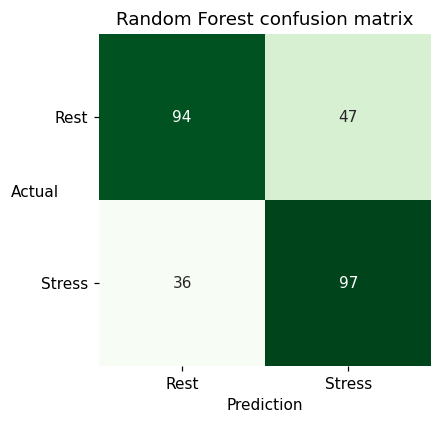

In [19]:
"""from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, max_features = 2, n_jobs=1)
rf.fit(X_train,y_train)

# pickle the rf model
with open('5_min_rf.pickle', 'wb') as to_write:
    pickle.dump(rf, to_write)

y_pred = rf.predict(X_val)"""

# read in the model
with open('5_min_rf.pickle','rb') as read_file:
    rf = pickle.load(read_file)

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, recall_score, precision_score, accuracy_score

# This is the updated threshold where precision and recall cross over
y_preds = (rf.predict_proba(X_val)[:, 1] > 0.5)
print(classification_report(y_val, y_preds))

import seaborn as sns
cf_matrix = confusion_matrix(y_val, y_preds)
plt.figure(dpi=110)
sns.heatmap(cf_matrix, cmap=plt.cm.Greens, annot=True, square=True, fmt='g',
           xticklabels=['Rest','Stress'],
           yticklabels=['Rest','Stress'],
           cbar=False)
plt.yticks(rotation=0) 
plt.xlabel('Prediction')
plt.ylabel('Actual',rotation=0)
plt.title('Random Forest confusion matrix');

# Plot user 1 HRV through the day

In [7]:
user_1_RR = RR_df[RR_df['User']==1]

In [8]:
times = []
u1RRs = []
for i in range(len(user_1_RR)):
    current_time = pd.to_datetime(user_1_RR.time.iloc[i], format='%H:%M:%S').time()
    if i == 0:
        start_time = current_time
        end_time = (dt.datetime.combine(dt.date(1,1,1),start_time) + dt.timedelta(minutes = 1)).time()
        times.append(current_time)
        tmp_RRs = []
        tmp_RRs.append(user_1_RR.ibi_s.iloc[i])
    elif current_time >= end_time:
        times.append(current_time)
        start_time = current_time
        end_time = (dt.datetime.combine(dt.date(1,1,1),start_time) + dt.timedelta(minutes = 1)).time()
        tmp_RRs = []
        tmp_RRs.append(user_1_RR.ibi_s.iloc[i])
        u1RRs.append(tmp_RRs)
    elif i == (len(user_1_RR)-1):
        u1RRs.append(tmp_RRs)
    else:
        tmp_RRs.append(user_1_RR.ibi_s.iloc[i])
    

In [9]:
u1_filtered_RRs=[]
for series in u1RRs:
    filtered = [i for i in series if ((i > 0.3) & (i < 3))]
    filtered_mean = np.mean(filtered)
    filtered_std = np.std(filtered)
    lower = filtered_mean-filtered_std
    upper = filtered_mean+filtered_std
    u1_filtered_RRs.append([i for i in filtered if ((i >= lower) & (i <= upper))])

In [10]:
u1RMSSDs = [RMSSD(series) for series in u1_filtered_RRs]

No handles with labels found to put in legend.


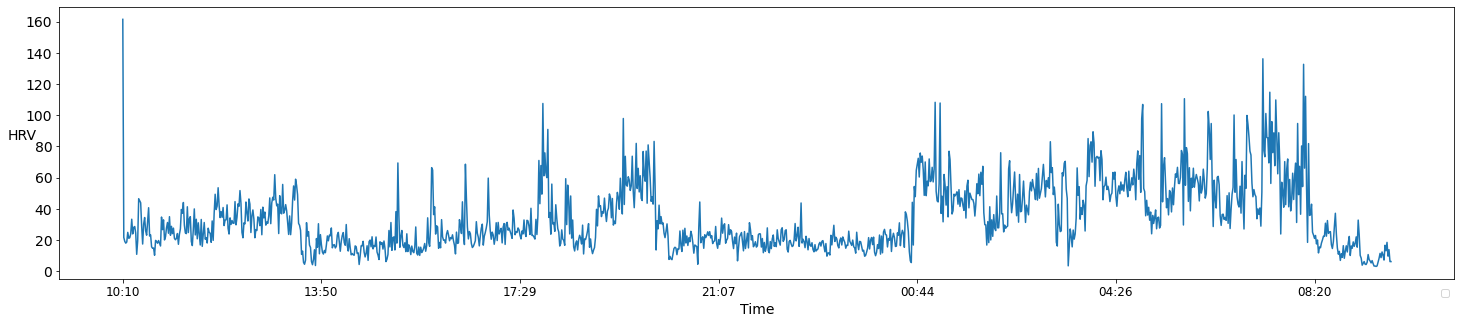

In [20]:
time_ticks = []
for i in np.arange(0,1300,200):
    time_ticks.append(times[i].strftime('%H:%M'))

x = np.arange(0,1278,1)
plt.figure(figsize=(25,5))
plt.plot(x, u1RMSSDs)

"""
#sleep
plt.fill_between(x,u1RMSSDs,0, where=(x>=802)&(x<951), color='lightblue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=975)&(x<1166), color='lightblue', label='sleep')

# caffeine
plt.fill_between(x,u1RMSSDs,0, where=(x>=27)&(x<32), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=186)&(x<191), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=232)&(x<237), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=356)&(x<360), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=437)&(x<446), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=635)&(x<639), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=667)&(x<672), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=699)&(x<704), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=732)&(x<736), color='blue', label='Caffeine')

# Exercise
plt.fill_between(x,u1RMSSDs,0, where=(x>=41)&(x<45), color='red')
plt.fill_between(x,u1RMSSDs,0, where=(x>=205)&(x<237), color='red')
plt.fill_between(x,u1RMSSDs,0, where=(x>=566)&(x<621), color='red')
plt.fill_between(x,u1RMSSDs,0, where=(x>=639)&(x<668), color='red', label='Exercise')

# Laying Down
plt.fill_between(x,u1RMSSDs,0, where=(x>=0)&(x<10), color='limegreen')
plt.fill_between(x,u1RMSSDs,0, where=(x>=45)&(x<64), color='limegreen')
plt.fill_between(x,u1RMSSDs,0, where=(x>=237)&(x<356), color='limegreen')
plt.fill_between(x,u1RMSSDs,0, where=(x>=360)&(x<437), color='limegreen', label='Laying Down')

# Computer/phone
plt.fill_between(x,u1RMSSDs,0, where=(x>=483)&(x<524), color='limegreen', label='Computer')
"""

plt.legend(bbox_to_anchor=(1, -.02), fontsize=10)
plt.xlabel('Time', fontsize=14)
plt.ylabel('HRV', fontsize=14, rotation = 0)
plt.yticks(fontsize=14)
plt.xticks(np.arange(0,1300,200), time_ticks, fontsize=12);